In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

     |████████████████████████████████| 36.1MB 180kB/s 


In [ ]:
from keras import utils
from keras.models import Sequential,model_from_yaml
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM, GRU
from keras.layers import TimeDistributed, Conv3D,MaxPooling3D, ZeroPadding3D
from keras.layers import Bidirectional
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from imutils import face_utils

from sklearn.preprocessing import MinMaxScaler

import os
import shutil
import re

import imutils
import dlib
import numpy as np
import cv2
import math
import random

import matplotlib.pyplot as plt

import mediapipe as mp

# Dlib Shape Predictor

---

Loading the shape predictor that will locate the landmarks of any detected faces in an image

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_face_mesh = mp.solutions.face_mesh

In [ ]:
numbers = re.compile(r'(\d+)')

In [ ]:
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Data Preprocessing

---


Takes all the frames of a video as input and returns 20 euclidean distances for each of these frames

In [ ]:
def preprocessing(video_path, frame_list):

    euclid_dist = np.empty(shape=(25,40))
    inner_count = 0
    lips = [0, 13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409, 415]
    for f in frame_list:
        frame_path = os.path.join(video_path,f)
        with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5) as face_mesh:
          frame = cv2.imread(frame_path)        
          # Convert the BGR image to RGB before processing.
          results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

          # Print and draw face mesh landmarks on the image.
          if results.multi_face_landmarks:
              mean_x,mean_y = 0,0
              for n in lips:
                  x_mouth = results.multi_face_landmarks[0].landmark[n].x
                  y_mouth = results.multi_face_landmarks[0].landmark[n].y

                  shape = frame.shape 
                  relative_x = int(x_mouth * shape[1])
                  relative_y = int(y_mouth * shape[0])
                  mean_x = mean_x + relative_x
                  mean_y = mean_y + relative_y
              mean_x = mean_x/40
              mean_y = mean_y/40
              int_count = 0
              for n in lips:
                  x_mouth = results.multi_face_landmarks[0].landmark[n].x
                  y_mouth = results.multi_face_landmarks[0].landmark[n].y

                  shape = frame.shape 
                  relative_x = int(x_mouth * shape[1])
                  relative_y = int(y_mouth * shape[0])
                  euclid_dist[inner_count,int_count] = math.sqrt(math.pow((mean_x-relative_x),2)+math.pow((mean_y-relative_y),2))
                  int_count += 1
          inner_count +=1  

    return euclid_dist,1

# Data Generator

---

Creation of X_train, X_val, X_test, y_train, y_val, y_test arrays

In [ ]:
def data_generator(word, class_dict):
    #TRAINING SET 
    first_flag,actual_count = 0,0
    speakers=os.listdir(train_set)
    for s in speakers:
        repetition = os.listdir(os.path.join(os.path.join(train_set,s),word))
        for rep in repetition:
            video_path = os.path.join(os.path.join(os.path.join(train_set,s),word),rep)
            frame_list=os.listdir(video_path)
            frame_list.sort(key=numericalSort)
            temp,bool_flag = preprocessing(video_path, frame_list)  
            #ONLY FOR FIRST VIDEO
            if bool_flag == 1 and first_flag == 0:
                X_train = temp
                first_flag = 1
                actual_count += 1

            #FOR REST OF THE VIDEOS
            elif bool_flag == 1:
                X_train = np.append(X_train,temp,axis=0)
                actual_count += 1

            print("{}/{}".format(actual_count,700))

    X_train = X_train.reshape(actual_count,25,40).astype('float32')
    y_train = [None]*actual_count 
    for i in range(actual_count):
        y_train[i] = class_dict[word]

    #VALIDATION SET
    first_flag,actual_count = 0,0
    speakers=os.listdir(val_set)
    for s in speakers:
        repetition = os.listdir(os.path.join(os.path.join(val_set,s),word))
        for rep in repetition:
            video_path = os.path.join(os.path.join(os.path.join(val_set,s),word),rep)
            frame_list = os.listdir(video_path)
            frame_list.sort(key=numericalSort)

            temp,bool_flag = preprocessing(video_path, frame_list)  

            if bool_flag == 1 and first_flag == 0:
                X_val = temp
                first_flag = 1
                actual_count += 1

            elif bool_flag == 1:
                X_val = np.append(X_val,temp,axis=0)
                actual_count += 1

            print("{}/{}".format(actual_count,210))

    X_val = X_val.reshape(actual_count,25,40).astype('float32')

    y_val = [None]*actual_count 
    for i in range(actual_count):
        y_val[i] = class_dict[word]



    #TEST SET#
    first_flag,actual_count = 0,0
    speakers=os.listdir(test_set)
    for s in speakers:
        repetition = os.listdir(os.path.join(os.path.join(test_set,s),word))
        for rep in repetition:
            video_path = os.path.join(os.path.join(os.path.join(test_set,s),word),rep)
            frame_list = os.listdir(video_path)
            frame_list.sort(key=numericalSort)

            temp,bool_flag = preprocessing(video_path, frame_list)  

            if bool_flag == 1 and first_flag == 0:
                X_test = temp
                first_flag = 1
                actual_count += 1

            elif bool_flag == 1:
                X_test = np.append(X_test,temp,axis=0)
                actual_count += 1

            print("{}/{}".format(actual_count,140))
    X_test = X_test.reshape(actual_count,25,40).astype('float32')

    y_test = [None]*actual_count 
    for i in range(actual_count):
        y_test[i] = class_dict[word]

    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    y_val = np.asarray(y_val)

    return X_train,y_train,X_val,y_val,X_test,y_test

# Array Creation

---

Creating the train, validation and test sets for each class in the list of classes

In [ ]:
def create_dataset(class_dict):
    first_flag, counter = 0,0
    for word in class_dict.keys():
        trainX,trainY,valX,valY,testX,testY = data_generator(word, class_dict)

        if first_flag == 0:
            X_train = trainX
            X_test = testX
            X_val = valX
            y_train = trainY
            y_test = testY
            y_val = valY
            first_flag = 1
        else:
            X_train = np.append(X_train,trainX,axis=0)
            X_test = np.append(X_test,testX,axis=0)
            X_val = np.append(X_val,valX,axis=0)
            y_train = np.append(y_train,trainY,axis=0)
            y_test = np.append(y_test,testY,axis=0)
            y_val = np.append(y_val,valY,axis=0)

        counter+=1        
        print("Words processed:{}/{}".format(counter,10))

    y_train = utils.to_categorical(y_train)
    y_test = utils.to_categorical(y_test)
    y_val = utils.to_categorical(y_val)

    return X_train,X_test,X_val,y_val,y_train,y_test

In [ ]:
actual_class_dict = {'01':'Begin','02':'Choose','03':'Connection','04':'Navigation','05':'Next','06':'Previous','07':'Start','08':'Stop','09':'Hello','10':'Web'}
class_dict = {'01':1,'02':2,'03':3,'04':4,'05':5,'06':6,'07':7,'08':8,'09':9,'10':10}

In [ ]:
train_set = "/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/train_set"
val_set = "/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/val_set"
test_set = "/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/test_set"

In [ ]:
#Save new data
X_train,X_test,X_val,y_val,y_train,y_test = create_dataset(class_dict) 
np.save('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/X_train3.npy',X_train)
np.save('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/X_test3.npy',X_test)
np.save('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/X_val3.npy',X_val)
np.save('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/y_train3.npy',y_train)
np.save('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/y_test3.npy',y_test)
np.save('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/y_val3.npy',y_val)

1/700
2/700
3/700
4/700
5/700
6/700
7/700
8/700
9/700
10/700
11/700
12/700
13/700
14/700
15/700
16/700
17/700
18/700
19/700
20/700
21/700
22/700
23/700
24/700
25/700
26/700
27/700
28/700
29/700
30/700
31/700
32/700
33/700
34/700
35/700
36/700
37/700
38/700
39/700
40/700
41/700
42/700
43/700
44/700
45/700
46/700
47/700
48/700
49/700
50/700
51/700
52/700
53/700
54/700
55/700
56/700
57/700
58/700
59/700
60/700
61/700
62/700
63/700
64/700
65/700
66/700
67/700
68/700
69/700
70/700
71/700
72/700
73/700
74/700
75/700
76/700
77/700
78/700
79/700
80/700
81/700
82/700
83/700
84/700
85/700
86/700
87/700
88/700
89/700
90/700
91/700
92/700
93/700
94/700
95/700
96/700
97/700
98/700
99/700
100/700
1/210
2/210
3/210
4/210
5/210
6/210
7/210
8/210
9/210
10/210
11/210
12/210
13/210
14/210
15/210
16/210
17/210
18/210
19/210
20/210
21/210
22/210
23/210
24/210
25/210
26/210
27/210
28/210
29/210
30/210
1/140
2/140
3/140
4/140
5/140
6/140
7/140
8/140
9/140
10/140
11/140
12/140
13/140
14/140
15/140
16/140
17/1

In [ ]:
X_train = np.load('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/X_train3.npy')/2.56
X_test = np.load('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/X_test3.npy')/2.56
X_val = np.load('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/X_val3.npy')/2.56
y_train = np.load('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/y_train3.npy')
y_test = np.load('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/y_test3.npy')
y_val = np.load('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/y_val3.npy')

y_train = np.delete(y_train,0,1)
y_val = np.delete(y_val,0,1)
y_test = np.delete(y_test,0,1)

In [ ]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape,X_test.shape,y_test.shape

((1000, 25, 40),
 (300, 25, 40),
 (1000, 10),
 (300, 10),
 (200, 25, 40),
 (200, 10))

In [ ]:
count=1000
while count>0:
  for i in range(count-1,count-101,-1):
    flag=0
    for j in range(25):
      for k in range(40):
        if (np.isinf(X_train[i][j][k])==True):
          X_train[i]=X_train[count-1]
          flag=1
          break;
      if flag==1:
        break
  count-=100

In [ ]:
count=300
while count>0:
  for i in range(count-1,count-31,-1):
    flag=0
    for j in range(25):
      for k in range(40):
        if (np.isinf(X_val[i][j][k])==True):
          X_val[i]=X_val[count-1]
          flag=1
          break;
      if flag==1:
        break
  count-=30

In [ ]:
count=200
while count>0:
  for i in range(count-1,count-21,-1):
    flag=0
    for j in range(25):
      for k in range(40):
        if (np.isinf(X_test[i][j][k])==True):
          X_test[i]=X_test[count-1]
          flag=1
          break;
      if flag==1:
        break
  count-=20

In [ ]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape, X_test.shape, y_test.shape

((1000, 25, 40),
 (300, 25, 40),
 (1000, 10),
 (300, 10),
 (200, 25, 40),
 (200, 10))

In [ ]:
# scalers = {}
# for i in range(X_train.shape[1]):
#     scalers[i] = MinMaxScaler()
#     X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :])
# for i in range(X_val.shape[1]):
#     scalers[i] = MinMaxScaler()
#     X_val[:, i, :] = scalers[i].fit_transform(X_val[:, i, :])
# for i in range(X_test.shape[1]):
#     scalers[i] = MinMaxScaler()
#     X_test[:, i, :] = scalers[i].fit_transform(X_test[:, i, :])


In [ ]:
# np.isnan(X_train).any(),np.isnan(y_train).any(),np.isnan(X_test).any(),np.isnan(y_test).any(),np.isnan(X_val).any(),np.isnan(y_val).any()

# Model Creation and Fitting

---

Creating and fitting the model containing a Bidirectional LSTM layer and a Softmax function for classification of 10 classes

In [ ]:
#BiLSTM network
model = Sequential()
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [ ]:
#Fitting the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(X_train, y_train,validation_data=(X_val,y_val), epochs=4000, batch_size=40, callbacks=[es,mc])
model.summary()

Epoch 1/4000
25/25 [==============================] - 6s 105ms/step - loss: 2.3844 - accuracy: 0.0954 - val_loss: 2.3097 - val_accuracy: 0.1000

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/drive/MyDrive/Project/miracl-vc1-copy/new_split/best_model.h5
Epoch 2/4000
25/25 [==============================] - 1s 45ms/step - loss: 2.3460 - accuracy: 0.1149 - val_loss: 2.3067 - val_accuracy: 0.1000

Epoch 00002: val_accuracy did not improve from 0.10000
Epoch 3/4000
25/25 [==============================] - 1s 46ms/step - loss: 2.3196 - accuracy: 0.1094 - val_loss: 2.3055 - val_accuracy: 0.1000

Epoch 00003: val_accuracy did not improve from 0.10000
Epoch 4/4000
25/25 [==============================] - 1s 46ms/step - loss: 2.3271 - accuracy: 0.1021 - val_loss: 2.3048 - val_accuracy: 0.1000

Epoch 00004: val_accuracy did not improve from 0.10000
Epoch 5/4000
25/25 [==============================] - 1s 48ms/step - loss: 2.3118 - accuracy: 0.0974 - val_loss: 2

Train: 0.881, Test: 0.370


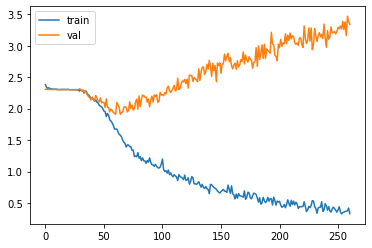

In [ ]:
saved_model = load_model('/content/drive/MyDrive/Project/miracl-vc1-copy/new_split/best_model.h5')
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = saved_model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, val_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# #Testing the model
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
scores,acc = saved_model.evaluate(X_test, y_test,verbose=0)
model.summary()
print("Accuracy on the test set: {}%".format(acc*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                26880     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 27,530
Trainable params: 27,530
Non-trainable params: 0
_________________________________________________________________
Accuracy on the test set: 21.50000035762787%


# Testing

---
Running tests on the videos in the test set and predicting the output and their probabilities

In [ ]:
speakers=os.listdir(test_set)
for s in speakers:
    word_list = os.listdir(os.path.join(test_set,s))
    for word in word_list:
        repetition = os.listdir(os.path.join(os.path.join(test_set,s),word))
        for rep in repetition:
            test_video_path = os.path.join(os.path.join(os.path.join(test_set,s),word),rep)
            frame_list = os.listdir(test_video_path)
            frame_list.sort(key=numericalSort)
            
            test,bool_flag = preprocessing(test_video_path, frame_list) 
            test = test.reshape((1,25,20))
            y = int(np.argmax(model.predict(test), axis=-1))
            y2 = model.predict_proba(test)
            temp = list(class_dict.keys())
            print("The predicted word for {} is {} ".format(actual_class_dict[word],actual_class_dict[temp[y]]))
            print(y2)
            print("\n")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


The predicted word for Connection is Connection 
[[3.8233811e-06 4.6588422e-04 9.8258787e-01 8.6658629e-06 2.4701946e-04
  1.0182909e-04 1.2560005e-07 5.1781649e-07 5.3466326e-08 1.6584208e-02]]


The predicted word for Choose is Choose 
[[1.5236832e-04 9.9178892e-01 5.4149909e-06 3.1156321e-06 1.9710892e-06
  5.3037624e-03 2.0204898e-06 2.5505738e-03 3.4985121e-06 1.8836035e-04]]


The predicted word for Begin is Begin 
[[9.9453294e-01 8.5142870e-05 1.7602191e-05 1.1382428e-04 6.7341223e-04
  4.3244790e-03 9.5279502e-05 2.0911053e-05 1.8575730e-06 1.3461393e-04]]


The predicted word for Next is Next 
[[6.4947279e-05 7.5270563e-09 2.0318645e-07 1.7423552e-05 9.9987376e-01
  1.0356230e-06 2.6550913e-06 2.3822951e-08 3.9832543e-05 4.0602963e-08]]


The predicted word for Navigation is Navigation 
[[2.3765751e-06 3.2360512e-07 5.6855079e-06 9.9978060e-01 2.9903875e-05
  5.9629942e-06 8.4309559e-06 2.3833195e-07 1.6650054e-04 3.2377345e-10]]


The predicted word for Hello is Hello 
[[6.34

# Graphs

---

Accuracy and loss graphs for the model

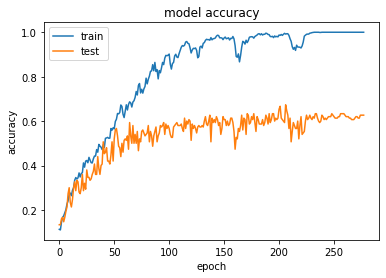

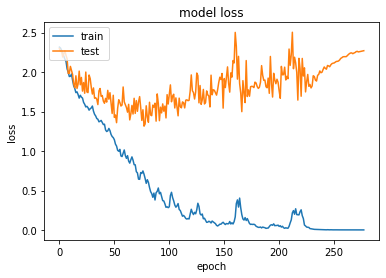

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()